   owner_avg_likesCount  owner_var_likesCount  owner_std_likesCount
0           1246.714286          1.820922e+05            426.722671
2          10991.833333          2.820424e+07           5310.766848
3           1246.714286          1.820922e+05            426.722671
4          17687.750000          2.988308e+07           5466.541569
5          17687.750000          2.988308e+07           5466.541569
피쳐셀렉 안했을때
Mean Squared Error: 1200383767.49187160
Mean Absolute Error: 18650.56668
R² Score: 0.51
mean_absolute_percentage_erro: 0.78
Normalized MAE (by user group std): 0.98553
-----------------------------------
피쳐셀렉 햇을때
Mean Squared Error: 844630341.25874341
Mean Absolute Error: 14211.45190
R² Score: 0.66
mean_absolute_percentage_erro: 0.44
Normalized MAE (by user group std): 0.56358


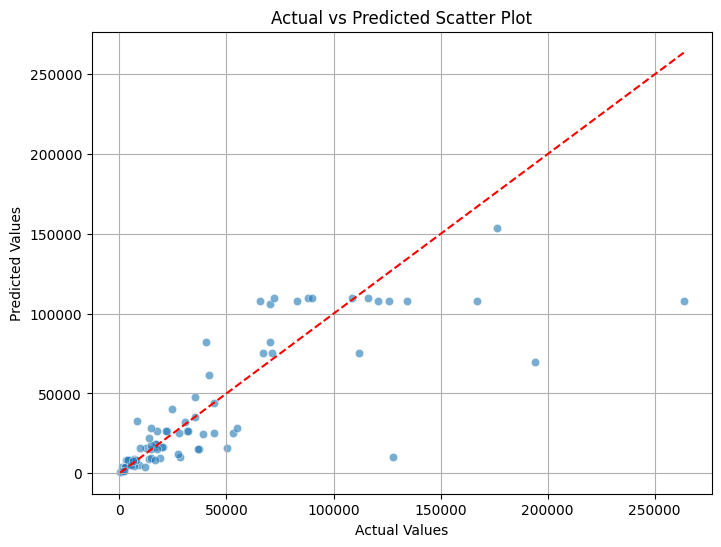

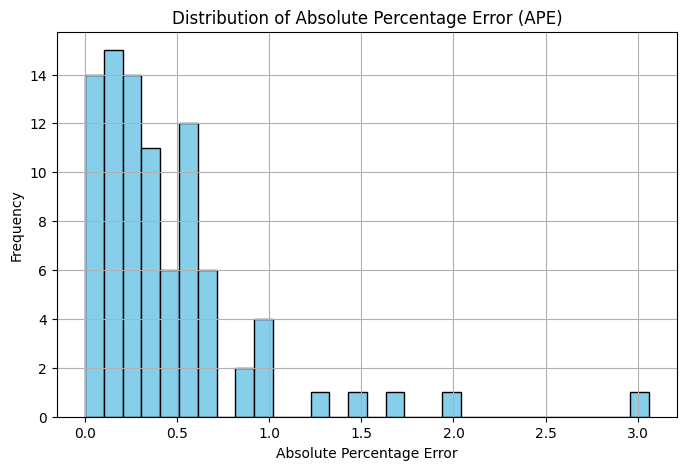

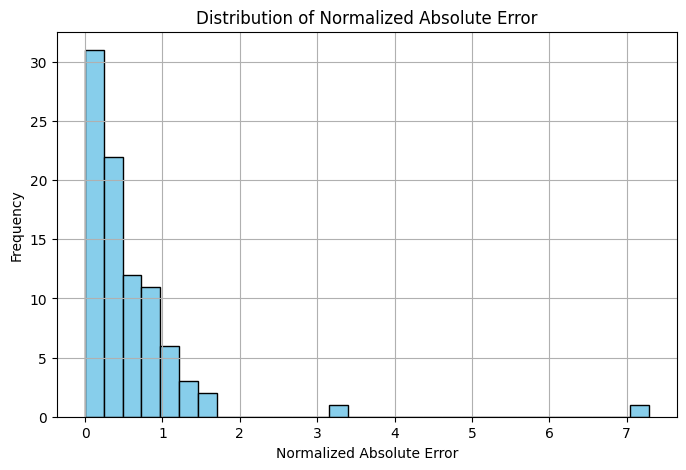

In [2]:
import pandas as pd
import json

df = pd.read_csv('C:\\Users\\장재요원지\\Downloads\\merged_dataset_post_with_images_with_captions.csv', encoding='utf-8')


#해시태그 개수를 해시태그 카운트로
#멘션 개수를 멘션 카운트로
def count_hashtags(x):
    if pd.isna(x):
        return 0
    # 빈 문자열 처리
    x = x.strip()
    if not x:
        return 0
    return len([tag for tag in x.split(',') if tag.strip()])

df['hashtag_count'] = df['hashtags'].apply(count_hashtags)
df['mention_count'] = df['mentions'].apply(count_hashtags)

df=df.drop(columns=['mentions','hashtags'])

df=df[df['caption'].isna()==False]
#캡션길이 생성
df_captionlen=df['caption'].apply(lambda x: len(x))
df['captionlen']=df_captionlen


from datetime import datetime

df["day_of_week"] = df["timestamp"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ").strftime("%A"))
df["hour"] = df["timestamp"].apply(lambda x: int(datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ").strftime("%H")))
df["day_of_year"] = df["timestamp"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ").strftime("%Y"))


df2=df.drop(columns=['caption','timestamp','owner_fullName','owner_verified','owner_biography','isSponsored','images'])

df2['day_of_year']=df2['day_of_year'].astype(int)

df2 = pd.get_dummies(
    df2,
    columns=['day_of_week', 'owner_businessCategoryName'],
    dtype=int  # int로 지정
)

df2=df2[df2['owner_id'].isna()==False]

df2 = df2[df2['likesCount'] >= 0]

# owner_id별 likesCount 평균
df2['owner_avg_likesCount'] = df2.groupby('owner_id')['likesCount'].transform('mean')

# owner_id별 likesCount 중앙값
df2['owner_median_likesCount'] = df2.groupby('owner_id')['likesCount'].transform('median')
df2['owner_median_commentCount'] = df2.groupby('owner_id')['commentsCount'].transform('median')
df2['owner_var_likesCount'] = df2.groupby('owner_id')['likesCount'].transform('var')
import numpy as np
# 표준편차 컬럼 추가 (루트 분산)
df2['owner_std_likesCount'] = np.sqrt(df2['owner_var_likesCount'])
# 결과 확인
print(df2[['owner_avg_likesCount', 'owner_var_likesCount', 'owner_std_likesCount']].head())
df2['mean_impress']=df2['owner_avg_likesCount']/df2['owner_followersCount']

# 최종 좋아요 예측하기
y = df2['likesCount'] # y는 likesCount와 commentsCount

x = df2.drop(columns=['owner_businessCategoryName_None,Health/beauty','mean_impress','owner_median_commentCount','owner_id','likesCount', 'commentsCount','impression'])  # 나머지 열은 x
#x = df2.drop(columns=['likesCount', 'impression'])  # 나머지 열은 x

counts = x['owner_followersCount'].value_counts()
x = x[x['owner_followersCount'].isin(counts[counts > 1].index)]
y = y[x.index]
x=x.drop(columns="image_captions")

import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error
import xgboost as xgb
import pyswarms as ps
'''''
# 1. 데이터 준비
# x, y는 전체 데이터셋 (DataFrame 또는 numpy array)
# x: 입력 피처, y: 타깃

# 2. 데이터 분할 (8:2, stratify 옵션은 회귀에서는 보통 사용하지 않음)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=102
)

# 3. MinMax 스케일링
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# 4. PSO용 목적 함수 정의 (여기서는 XGBoost 회귀의 MSE를 최소화)
def pso_objective_function(mask):
    mask = mask.astype(bool)
    if not np.any(mask):
        return 1e10  # 아무 피처도 선택 안 하면 큰 값 반환
    x_selected = x_train_scaled[:, mask]
    x_val, x_holdout, y_val, y_holdout = train_test_split(
        x_selected, y_train, test_size=0.2, random_state=42
    )
    model = xgb.XGBRegressor()
    model.fit(x_val, y_val)
    y_pred = model.predict(x_holdout)
    mse = mean_squared_error(y_holdout, y_pred)
    # 피처 개수에 대한 패널티 추가 가능 (선택 피처 수가 적을수록 유리하게)
    penalty = 0.01 * np.sum(mask)
    return mse + penalty

# 5. PSO로 피처 셀렉션 (Binary PSO)
n_features = x_train_scaled.shape[1]
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 2}
optimizer = ps.discrete.BinaryPSO(n_particles=20, dimensions=n_features, options=options)

# 목적 함수는 각 파티클(피처 선택 마스크)에 대해 평가
cost, pos = optimizer.optimize(
    lambda mask, **kwargs: np.array([pso_objective_function(m) for m in mask]), 
    iters=100, print_step=5, verbose=2
)

# 6. 선택된 피처 마스크 확인
selected_features = pos.astype(bool)
selected_feature_names = x.columns[selected_features]

print("Selected features:", np.where(selected_features)[0])
print("Number of selected features:", selected_features.sum())
print("Selected feature names:")
for name in selected_feature_names:
    print(name)
print("Selected feature names:")
for name in selected_feature_names:
    print(name)
# 7. 선택된 피처만으로 XGBoost 회귀 학습/평가

'''''
selected_features1= [ 2 , 6 ,14, 18, 19, 20, 22, 23 ,24 ,25, 28, 31]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=102
)

# 3. MinMax 스케일링
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

x_train_sel = x_train_scaled[:, selected_features1]
x_test_sel = x_test_scaled[:, selected_features1]
x_t=x_test
model = xgb.XGBRegressor()
model0 = xgb.XGBRegressor()
model0.fit(x_train_scaled, y_train)
model.fit(x_train_sel, y_train)

y_pred0 = model0.predict(x_test_scaled)

y_pred = model.predict(x_test_sel)


print("피쳐셀렉 안했을때")
mse0 = mean_squared_error(y_test, y_pred0)
mae0 = mean_absolute_error(y_test, y_pred0)
r20 = r2_score(y_test, y_pred0)
print(f"Mean Squared Error: {mse0:.8f}")
print(f"Mean Absolute Error: {mae0:.5f}")
print(f"R² Score: {r20:.2f}")

mape0=mean_absolute_percentage_error(y_test, y_pred0)
print(f"mean_absolute_percentage_erro: {mape0:.2f}")
owner_std = np.sqrt(x_t['owner_var_likesCount'].values)  # 표준편차로 변환
nmae0 = np.mean(np.abs(y_test - y_pred0) / owner_std)
print(f"Normalized MAE (by user group std): {nmae0:.5f}")
print("-----------------------------------")
print("피쳐셀렉 햇을때")
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.8f}")
print(f"Mean Absolute Error: {mae:.5f}")
print(f"R² Score: {r2:.2f}")
from sklearn.metrics import mean_absolute_percentage_error
mape=mean_absolute_percentage_error(y_test, y_pred)
print(f"mean_absolute_percentage_erro: {mape:.2f}")
owner_std = np.sqrt(x_t['owner_var_likesCount'].values)  # 표준편차로 변환

# 분산이 0인 경우 1로 대체(0으로 나누는 오류 방지)
owner_std[owner_std == 0] = 1

# 정규화 MAE (NMAE)
nmae = np.mean(np.abs(y_test - y_pred) / owner_std)
print(f"Normalized MAE (by user group std): {nmae:.5f}")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # 완벽 예측선
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Scatter Plot')
plt.grid(True)
plt.show()



# APE 계산
ape = np.abs((y_test - y_pred) / y_test)

# 히스토그램 시각화
plt.figure(figsize=(8, 5))
plt.hist(ape, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Absolute Percentage Error (APE)')
plt.xlabel('Absolute Percentage Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# normalized_abs_error 계산
normalized_abs_error = np.abs(y_test - y_pred) / owner_std

# 분포 히스토그램 그리기
plt.figure(figsize=(8, 5))
plt.hist(normalized_abs_error, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Normalized Absolute Error')
plt.xlabel('Normalized Absolute Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

